# Exercice: Détection des cadres de lecture ouverts

Les cadre de lectures ouverts ([Open Reading Frame, ORF](https://en.wikipedia.org/wiki/Open_reading_frame)) sont la partie d'une séquence qui peut être traduite en protéine.  

On ignorera les introns. 

In [3]:
import numpy as np
import random

## Question 1: Écrire une fonction qui construit une séquence d'ADN générée aléatoirement de longueur N 


In [4]:
# Correction 1 - Distribution uniforme, en une ligne.
def random_sequence(size):
    """Return a random DNA sequence of length size as a string"""
    return ''.join([random.choice('ATGC') for _ in range(size)])

# Notez :
# - L'utilisation de la méthode join de la chaîne vide
# - La compréhension de liste
# - Une variable inutilisée en python doit être appelée "_" par convention
# - La chaîne 'ATGC' est utilisée comme itérateur par random.choice. 

# Correction 2 - Avec des poids. 
def random_sequence(size, letters=(('A', 1), ('T', 1), ('G',1), ('C', 1))):
    """Return a random sequence built from letters.
    Args:
        size (int): sequence length
        letters (iterable): each element is a couple (letter, weight).
        
    Return: (string) random sequence where the probability of each letter is
    proportional to its weight.
    """
    alphabet, weights = zip(*letters)
    array_of_letters = np.random.choice(alphabet, size=size, p=weights/np.sum(weights))
    return ''.join(array_of_letters)

# Notez que np.random.choice peut prendre des poids en argument. 
# Notez l'utilisation de zip(*letters)
# zip(*[(A,1), (B,2), (C,3)]) => zip((A,1), (B,2), (C,3)) => (A,B,C), (1,2,3)

#=> Pour des distributions plus compliquées, rendez-vous au cours de mathématiques 
#   quand nous verrons les châines de Markov !

## Question 2: Écrire une fonction qui recherche les codons d'initiation (ATG) dans une séquence 

In [5]:
# Correction 1:
def find_start(sequence):
    """Cherche la position des codons d'initiation."""
    pos = []
    for i in range(len(sequence) - 3):
        if sequence[i:i+3]=='ATG':
            pos.append(i)
    return pos 

# Correction 2:
def find_start2(sequence):
    """Utilise la méthode find des chaînes de caractère pour trouver la position des condons d'initiation."""
    i = 0 
    starts = []
    pos = 0
    while i<len(sequence):
        pos = sequence[i:].find('ATG')
        if pos>=0:
            starts.append(i+pos)
            i += pos + 3
        else:
            break
    return starts

# Correction 3:  
import re 
def find_start3(sequence):
    """Utilise des regexp pour trouver la position des condons d'initiation."""
    return [elt.start() for elt in re.finditer('ATG', sequence)]

In [6]:
# Vérifier que toutes les méthodes sont cohérentes.
test = 'ATGGCATCTCATTATTTCATGGGTAAATCTGA'
assert find_start(test) == [0,18] 
assert find_start2(test) == [0,18] 
assert find_start3(test) == [0,18] 

In [7]:
# On peut comparer le temps de chacune des méthodes...
print('Courte séquence:')
%timeit find_start(test)
%timeit find_start2(test)
%timeit find_start3(test)

print('\nLongue séquence:')
test2 = random_sequence(3000)
%timeit find_start(test2)
%timeit find_start2(test2)
%timeit find_start3(test2)

Courte séquence:
3.24 µs ± 62.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
938 ns ± 3.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.06 µs ± 4.85 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Longue séquence:
324 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
22.8 µs ± 297 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.2 µs ± 44.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
# Correction 4: Une version plus générale. 
def find_all(sequence, pattern='ATG', reading_frame=None, max_hits = None):
    """Find all indces of pattern in sequence.
    Args: 
        sequence (string): the sequence to search into.
        pattern (string): the pattern to search for. 
        reading_frames (int, tuple or None): reading frame to check, if None look in all reading frame.
        max_hits (int): max number of hits to return (all of them if None)
    Return: (list) list of position in sequence where pattern starts."""
    hits = []
    L = len(pattern)
    
    # Parse the value of the reading_frame argument.
    # Note the Duck-typing. 
    if reading_frame is None: 
        # If None, all reading frame
        reading_frame = range(len(pattern))
    try:
        iter(reading_frame)
    except TypeError:
        # If not iterable, make it iterable. 
        reading_frame = (reading_frame,)
    
    for rf in reading_frame:
        for i in range(rf, len(sequence)-L+1, L ):
            if sequence[i:i+L] == pattern:
                hits.append(i)
                if max_hits is not None and len(hits)>=max_hits:
                    break
    return hits

find_all('', 'ATG')

[]

## Question 3: Écrire une fonction qui recherche le premier codon stop (TAA, TAG, TGA) suivant un codon AUG dans le même cadre de lecture 

In [9]:
def matching_stop(sequence, start='ATG', stops=('TAA','TAG','TGA')):
    """ Return the position of each start codon and of the first following stop codon.
    If there is no stop codon after it, the start codon is ignored. 
    Args: 
        sequence (string): the sequence to search into.
        start (string): start codon
        stops (iter): list of stop codons
        
    """
    hits = []
    starts = find_all(sequence=sequence, pattern=start)
    for start in starts:
        stop_hits = []
        for stop in stops:
            for pos in find_all(sequence[start:], stop, reading_frame=0, max_hits=1):
                stop_hits.append(pos)
        if stop_hits:
            hits.append((start, start+np.min(stop_hits)))
    return hits
            
def matching_stop2(sequence):
    """Trouve les ORF non chevauchants à l'aide de la puissance des regexp."""
    return [(match.span(0)[0],match.span(2)[0]) for match in re.finditer('ATG([ATGC]{3})*?(TAA|TAG|TGA)', sequence)]
test = 'ATGAAATAGAATGTTGTAG'

In [10]:
test = 'ATGAAATAGAATGTTGTAG'
assert matching_stop(test) == [(0,6),(10,16)]
assert matching_stop2(test) == [(0,6),(10,16)]

# Exercice bonus: 
#- Expliquez la regexp de matching_stop2
#- Modifier matching_stop2 pour prendre en compte les ORF chevauchants.

## Question 4: Modifier la fonction pour qu'elle retourne la distance entre un codon d'initiation et le premier codon stop suivant dans le même cadre de lecture

In [11]:
def matching_stop_distance(sequence, start='ATG', stops=('TAA','TAG','TGA')):
    """ Return the position of the first stop codon after each start codon.
    Args: 
        sequence (string): the sequence to search into.
        start (string): start codon
        stops (iter): list of stop codons
    """
    dist = []
    starts = find_all(sequence=sequence, pattern=start)
    for start in starts:
        stop_hits = []
        for stop in stops:
            for pos in find_all(sequence[start:], stop, reading_frame=0, max_hits=1):
                stop_hits.append(pos)
        if stop_hits:
            dist.append(np.min(stop_hits))
    return dist

test = 'ATGAAATAGAATGTTGTAG'
matching_stop_distance(test)

[6, 6]

## Question 5: Déterminer quel est le nombre d'ORFs dans une séquence aléatoire d'ADN de longueur N. Pour chacun, calculer sa longueur.

#### Quel est le nombre d'ORF attendus dans une séquence aléatoire uniforme ?

Si on considère que la séquence est assez longue, on peut approximer le nombre d'ORF par le nombre de codon d'initiation.

Il y a $N-2$ codons (chevauchants) dans une séquence de N bases. Si on considère que tous les codons sont équiprobables, la probabilité qu'un codon soit un codon d'initiation est de $\frac{1}{64}$. Si on considère que tous les codons sont idépendants (ce qui n'est pas vraiment le cas parcequ'ils sont chevauchants), le nombre de codons d'initiation $M$ est binomial $M \sim Binom(N-2, 1/64)$. 

En moyenne il y a  $\mathbb E(M_N) = \frac{N-2}{64}$ ORF dans une séquence de taille $N$ selon ce modèle. Ce nombre est probablement sur-estimé, car il peut y avoir des codons d'initiation en fin de séquence qui ne forment pas d'ORF et que les codons ne sont pas vraiment indépendants.

#### Quelle est la longueur attendue d'un ORF dans une séquence aléatoire uniforme ?

Si la séquence est assez longue, l'ORF commence au codon d'initiation et se termine au premier codon stop rencontré. Sa longueur $L$ est donc géométriquement disitribuée, $L \sim Geom(3/64)$ (plus 1 si on compte le codon d'initiation et plus 2 si on compte aussi le codon stop). En moyenne cela fait $64$ bases.

$$\mathbb P(L=k) = 
\underbrace{\frac{61}{64}^k}_\text{non stop} 
\times
\underbrace{\frac{3}{64}}_\text{stop}$$

$$\mathbb E(L) = \frac{64}{3} \approx 21 \text{ codons}$$

In [12]:
R = 10 # Nombre de réplicas 
L = 1000 # Longueur maximale de la séquence
dist = {} # On va stocker l->liste des tailles
length_seq = np.arange(6, L, 1)
for _ in range(R):
    for l in length_seq:
        for d in matching_stop_distance(random_sequence(l)):
            try:
                dist[l].append(d)
            except KeyError:
                dist[l] = [d]
                
# Notez que l'on utilise le try/except pour ajouter les entrées de dictionnaire manquante.
# Une alternative à cette construction est d'utiliser collections.defaultdict(list)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

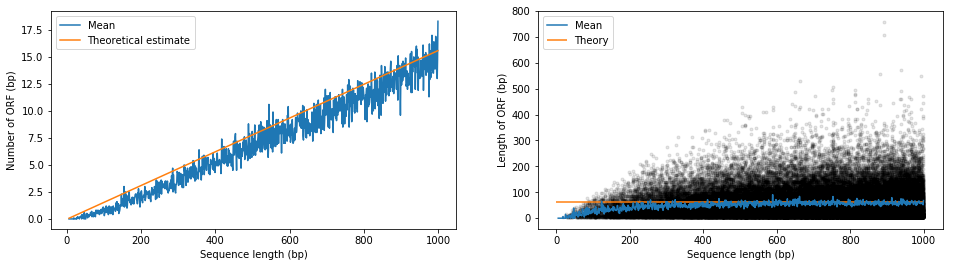

In [14]:
# Create the object figure and two axes.
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# in the first axis, we plot the ORF length as a function of sequence length.
ax[0].plot(length_seq, [len(dist[k])/R if k in dist else 0 for k in length_seq], label='Mean')
ax[0].set(xlabel='Sequence length (bp)', ylabel='Number of ORF (bp)')
ax[0].plot(length_seq, (length_seq-2)/64, label='Theoretical estimate')
ax[0].legend()

# In the second axis, we plot ORF length as a function of sequence length
for k,v in dist.items():
    ax[1].scatter([k]*len(v),v, color='k', marker='.', alpha=0.1)
ax[1].plot(length_seq, [np.mean(dist[k]) if k in dist else 0 for k in length_seq], label='Mean')
ax[1].hlines(64, 0,L, color='C1', label='Theory')
ax[1].legend() #=> display the labels
ax[1].set(xlabel='Sequence length (bp)', ylabel='Length of ORF (bp)');

## Question 6: Écrire un programme qui traduit une séquence nucléique en une série de protéines. 

On ignorera la transcription.

In [15]:
### Copié-collé depuis wikipédia:
data = """
Amino acid 	Codons 	Compressed 		Amino acid 	Codons 	Compressed
Ala / A 	GCU, GCC, GCA, GCG 	GCN 	Leu / L 	UUA, UUG, CUU, CUC, CUA, CUG 	YUR, CUN
Arg / R 	CGU, CGC, CGA, CGG, AGA, AGG 	CGN, MGR 	Lys / K 	AAA, AAG 	AAR
Asn / N 	AAU, AAC 	AAY 	Met / M 	AUG
Asp / D 	GAU, GAC 	GAY 	Phe / F 	UUU, UUC 	UUY
Cys / C 	UGU, UGC 	UGY 	Pro / P 	CCU, CCC, CCA, CCG 	CCN
Gln / Q 	CAA, CAG 	CAR 	Ser / S 	UCU, UCC, UCA, UCG, AGU, AGC 	UCN, AGY
Glu / E 	GAA, GAG 	GAR 	Thr / T 	ACU, ACC, ACA, ACG 	ACN
Gly / G 	GGU, GGC, GGA, GGG 	GGN 	Trp / W 	UGG
His / H 	CAU, CAC 	CAY 	Tyr / Y 	UAU, UAC 	UAY
Ile / I 	AUU, AUC, AUA 	AUH 	Val / V 	GUU, GUC, GUA, GUG 	GUN
START 	AUG 	STOP 	UAA, UGA, UAG 	UAR, URA"""

# On va construire un dictionnaire qui contient la correspondance ARN->Protéines
# C'est l'occasion d'exercer nos regexp. 
code = {}
for line in data.split('\n'):
    for m in re.finditer("[A-Za-z]{3} / ([A-Z]) \t([AUGC, ]*)",line):
        for codon in m.group(2).split(','):
            code[codon.strip()] = m.group(1)

for codon in re.search("STOP \t([AUGC, ]*)", data).group(1).split(','):
    code[codon.strip()] = '*'

assert len(code)==64

# Comme on va ignorer l'étape de transcription, remplaçons les U par des T:
code = {k.replace('U','T'):v for k,v in code.items()}

In [16]:
def traduction(sequence, code, taille_codon=3):
    """Traduit la séquence en utilisant le code.
        sequence (string): La séquence à traduire.
        code (dict): La correspondance codon->traduction.
        taille_codon (int): la taille d'un codon.
    Retourne la séquence traduite (string) Les codons non complets sont ignorés."""
    return ''.join(code[sequence[i:i+taille_codon]] 
                   for i in 
                   range(0,taille_codon*(len(sequence)//taille_codon),taille_codon))

assert traduction('ATGTTTTAG', code) == "MF*"
assert traduction('ATGTTTTAGT', code)  == "MF*"
assert traduction('', code) == "" 

def traduire_orf(sequence, code, taille_codon=3, start='ATG', stops=('TAA','TAG','TGA')):
    """Cherche les ORF et les traduit. 
        sequence (string): La séquence à traduire.
        code (dict): La correspondance codon->traduction.
        taille_codon (int): la taille d'un codon.
        start (string): start codon
        stops (iter): list of stop codons
    Retourne les protéines sous forme de liste.
    """
    orf = matching_stop(sequence, start=start, stops=stops)
    return [traduction(sequence[o[0]:o[1]], code, taille_codon) for o in orf]

assert traduire_orf('ATGTTTTAGTTCATGGGGGGGTAG', code) == ['MF', 'MGG']

## Question 7: Écrire une fonction pour lire et une pour écrire au format fasta

In [17]:
def from_fasta(text):
    """Convert a fasta-formatted string to a list of (key, sequence)"""
    out = []
    for seq in text.split('>'):
        lines = seq.split('\n')
        if seq and lines:
            out.append((lines[0].strip(), ''.join(lines[1:])))
    return out

def to_fasta(sequences, max_line_length=80):
    """Convert a list of (key,sequence) in a fasta-formatted string.
    Arg: 
        sequence (iterable of st): each element is key,sequence
        max_line_length (int): justify sequence with this length
    """
    lines = []
    for key, seq in sequences:
        lines.append('> {}'.format(key))
        for i in range(0,  max_line_length*(len(seq)//max_line_length+1), max_line_length):
            lines.append(seq[i:i+max_line_length])
    return '\n'.join(lines)

In [18]:
def read_fasta(path):
    """Read a fasta file from path, return a list of (key,sequence)."""
    with open(path, 'r') as file:
        return from_fasta(file.read())
def save_fasta(path, sequences, max_line_length=80):
    """Write an iterable of (key,sequence) into a fasta file."""
    with open(path,'w') as file:
        file.write(to_fasta(sequences, max_line_length=max_line_length))

In [19]:
# Quelques tests
test = """> Sequence of T
TTT
> Bases
ATGC"""
assert from_fasta(test) == [('Sequence of T', 'TTT'),('Bases','ATGC')]
assert test == to_fasta( [('Sequence of T', 'TTT'),('Bases','ATGC')]) 
assert len(from_fasta(to_fasta([('test_long','T'*120),]))[0][1])==120

test = [('test_long','G'*120),('test_court','T')]
save_fasta('test.fa', test)
assert read_fasta('test.fa') == test

## Question 8 : Exporter les positions d'ORF au format CSV

In [24]:
import pandas as pd

def matching_stop_table(sequence, start='ATG', stops=('TGA','TAA','TAG')):
    """ Return a pd.Dataframe contenant les ORF d'une sequence.
    Args: 
        sequence (string): the sequence to search into.
        start (string): start codon
        stops (iter): list of stop codons
    Return (pd.dataframe), avec colonnes: start, stop, stop_codon, length
    """
    data = []
    # construire le dataframe ligne par ligne. 
    for begin,end in matching_stop(sequence, start=start, stops=stops):
        data.append({'start':begin, 'end':end, 
                     'stop_codon':sequence[end:end+3]
                    })
    data = pd.DataFrame(data)
    data['length'] = data.end-data.start
    return data
test = 'ATGAAATAGAATGTTGTAA'
data = matching_stop_table(test)
data.to_csv('orf.csv')
data

,end,start,stop_codon,length
0,6,0,TAG,6
1,16,10,TAA,6
